In [9]:
import IPythonImporter
import GameFramework as gf

import copy
import random
import numpy as np

# English Auction

In [10]:


class Bid:
    
    def __init__(self, agent, price):
        self.agent = agent
        self.price = price
    
    def getAgent(self):
        return self.agent
    
    def getPrice(self):
        return self.price

class Auction:
    
    def __init__(self, scenario, site, request, maxBid, startBid):
        self.scenario = scenario
        self.site = site
        self.request = request
        self.maxBid = maxBid
        self.startBid = startBid
        self.bids = list()
        self.running = True
        self.sale = None
        self.lastRound = None
        
    def nextRound(self):
        # Keine Gebote -> Gewinner aus vorhergehender Runde ermitteln
        if len(self.bids) == 0:
            if self.lastRound != None and len(self.lastRound.bids) != 0:
                
                # Gebote mit minimalem Gebot in der vorherigen Runde
                minBidPrice = min([bid.getPrice() for bid in self.lastRound.bids])
                minBids = [bid for bid in self.lastRound.bids \
                           if bid.getPrice() == minBidPrice]
                
                # Wenn es nur ein Gebot mit minimalen Preis, dann dieses nehmen
                # -> ansonsten zufällig auswählen
                if len(minBids) == 1:
                    minBid = minBids[0]
                else:
                    minBid = random.choice(minBids)
                
                self.trySale(minBid)
            else:
                self.running = False
                self.sale = None
        
        # ein Gebot -> Auktion ist beendet
        elif len(self.bids) == 1:
            self.trySale(self.bids[0])        
                    
        # mehr als ein Gebot -> weiterverhandeln mit neuem Maximalpreis
        else:
            self.lastRound = copy.deepcopy(self)
            self.maxBid = min([bid.getPrice() for bid in self.bids])
            self.bids = list()
            
    def setBid(self, bid):
        if bid.price <= self.maxBid and self.running and self.sale == None:
            self.bids.append(bid)
    
    def trySale(self, bid):
        trySale = self.scenario.match(bid.getAgent(), self.site, self.request.skill, \
                                      self.request.amount, bid.getPrice())
        
        if trySale == True:
            self.sale = trySale
            self.running = False
            
            print "Ein neuer Verkauf: Baufirma " + str(bid.getAgent()) + \
                  " verkauft " + str(self.request.amount) + " Einheiten " + \
                  str(self.request.skill) + " an Baustelle " + str(self.site) + \
                  " für " + str(bid.getPrice()) + " Einheiten Geld."
        else:
            self.running = False
            self.sale = None

def trySaleE(auction, price, agent):
    trySale = auction.scenario.match(agent, auction.site, auction.request.skill, \
                                      auction.request.amount, price)
        
    if trySale == True:
        auction.sale = trySale
        auction.running = False
            
        print "Ein neuer Verkauf: Baufirma " + str(agent) + \
                " verkauft " + str(auction.request.amount) + " Einheiten " + \
                str(auction.request.skill) + " an Baustelle " + str(auction.site) + \
                " für " + str(price) + " Einheiten Geld."
    else:
        auction.running = False
        auction.sale = None
            
def englishAuction(scenario):

    for gameRound in range(100):
        print gameRound
        # -----------------------------------------------------------------
        # Auktionen in jeder Runde neu aufstellen:
        # -> Erste Runde startet mit dem Budget per Einheit bezogen auf 
        #    alle gesuchten Skills einer Baustelle
        # -> In jeder weiteren Runde wird der niedrigste Preis der vergan-
        #    gene Runde als neues Budget gewählt
        # -> Wird kein niedrigeres Gebot als das niedrigste Gebot in der 
        #    vorhergehenden Runde geboten, wird das niedrigste Gebot in 
        #    dieser Runde als Match genommen
        # -----------------------------------------------------------------
        if gameRound == 0:
            auctions = list()
            for site in scenario.sites:
                budgetPU = site.bud/np.sum(site.demand[:, 2])
                for req in site.requests:
                    auctions.append(Auction(scenario, site, req, int(req.amount*budgetPU), int(req.amount*budgetPU/4)))

        else: 
        # -------------------------------------------------------------------
        # Agenten reagieren mit Geboten auf die Auktionen:
        # -> Iterieren über alle Auktionen für jeden Agenten
        # -> Entscheidet ein Agent mit ja, dann wird die Auktion beendet
        #    Sonst wird das Budget erhöht
            for auction in auctions:
                for agent in scenario.agents:
                    for auction in auctions: 

                        if auction.startBid < auction.maxBid:
                            agentCosts = agent.getCosts(str(auction.request.skill), auction.request.amount, 
                                            scenario.distance(auction.site, agent))
               
                            if agentCosts is not None and agentCosts < (auction.startBid + auction.startBid/5):    
                                #auction[4].append([agent._id, (auction[3] - auction[3]/10) ])
                                trySaleE(auction, int(auction.startBid + auction.startBid/5), agent)
                            else:
                                auction.startBid = auction.startBid + auction.startBid/5

### Beispiel
Wir lassen den Mechanismus auf unser Standardszenario los und lassen uns nach jedem Match die schriftlichen Beschreibung des Spiels und den bipartiten Graphen ausgeben. Im Anschluss lassen wir uns Grafiken zu Auswertung des Spielverlaufes anzeigen.

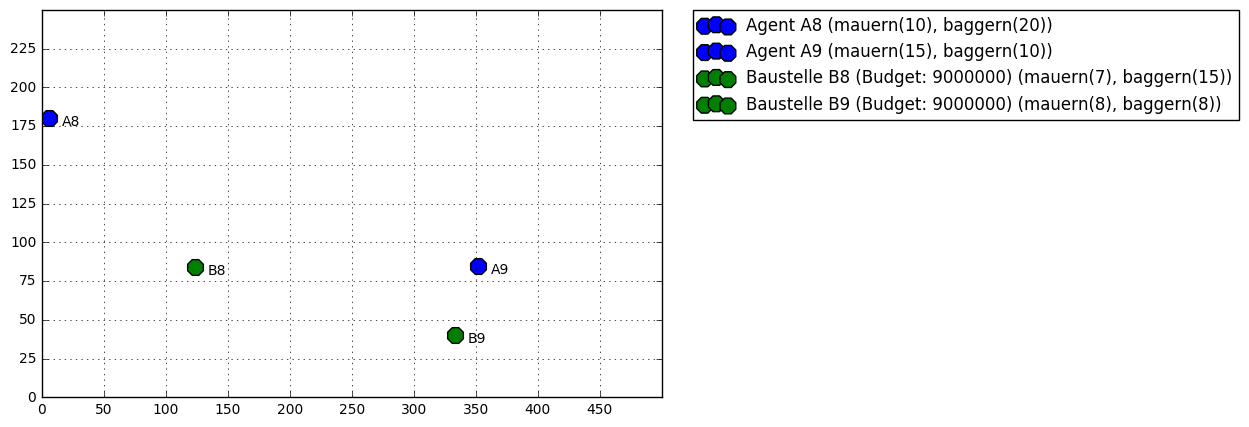

0
1
Ein neuer Verkauf: Baufirma Agent A8 (mauern(3), baggern(20)) verkauft 7 Einheiten mauern an Baustelle Baustelle B8 (Budget: 8140912) (mauern(0), baggern(15)) für 859088 Einheiten Geld.
Ein neuer Verkauf: Baufirma Agent A8 (mauern(3), baggern(5)) verkauft 15 Einheiten baggern an Baustelle Baustelle B8 (Budget: 6300008) (mauern(0), baggern(0)) für 1840904 Einheiten Geld.
Ein neuer Verkauf: Baufirma Agent A9 (mauern(7), baggern(10)) verkauft 8 Einheiten mauern an Baustelle Baustelle B9 (Budget: 7650000) (mauern(0), baggern(8)) für 1350000 Einheiten Geld.
Ein neuer Verkauf: Baufirma Agent A9 (mauern(7), baggern(2)) verkauft 8 Einheiten baggern an Baustelle Baustelle B9 (Budget: 6300000) (mauern(0), baggern(0)) für 1350000 Einheiten Geld.
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
8

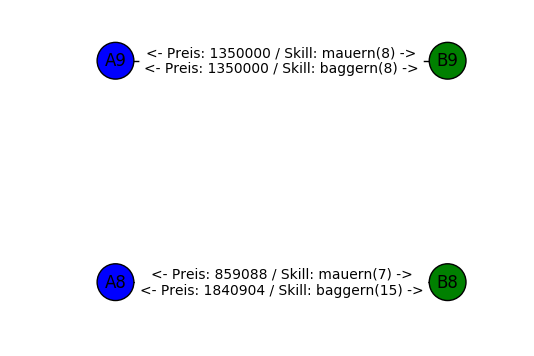

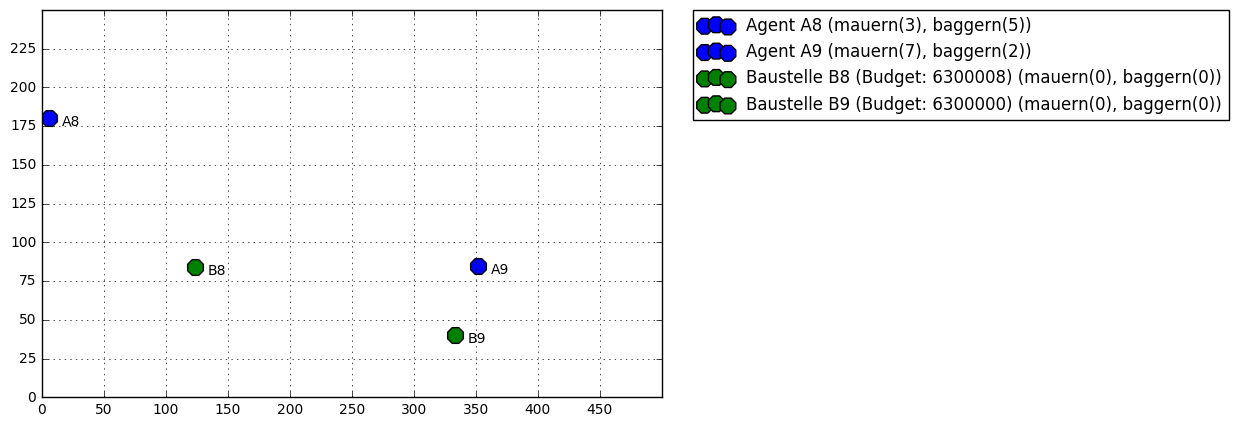

In [11]:
revScenario = gf.Scenario()
revScenario.plotMap()
englishAuction(revScenario)
revScenario.plotBiGraph()
revScenario.plotMap()